# Modeling Onion vs Not Onion
## Project 3: Subreddit Classification using NLP
### Robbie Davison

## 1) Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

<hr style='border-top: 50px solid #000;'> 

## 2) Read in Subreddit Data

In [2]:
master = pd.read_csv('./data/master_1_df.csv')

In [3]:
master.head()

,title,tag,score,y
0,I’m a Heterosexual Woman Who’s Politically Opp...,onion,1,1
1,Cruise Ship Erupts from Mt. St. Helen's After ...,onion,1,1
2,Is Our Wealth Hurting Africa's Feelings?,onion,1,1
3,Islam Is Incompatible With Country-Western Cul...,onion,1,1
4,Xi Jinping Vows To Combat Coronavirus By Makin...,onion,1,1


### Make Masks

In [4]:
onion = master['tag'] == 'onion'
not_onion = master['tag'] == 'not onion'
us_news = master['tag'] == 'us news'
world_news = master['tag'] == 'world news'
news = master['tag'] == 'news'
breitbart = master['tag'] == 'breitbart'

### Obtain 300 Reddits from each Non-Onion source and combine with Onion titles

In [5]:
data = pd.concat([
    master.loc[onion, :],
    master.loc[not_onion, :].sample(n=300, random_state=8),
    master.loc[us_news, :].sample(n=300, random_state=8),
    master.loc[world_news, :].sample(n=300, random_state=8),
    master.loc[news, :].sample(n=300, random_state=8),
    master.loc[breitbart, :].sample(n=300, random_state=8)
])

<hr style='border-top: 50px solid #000;'> 

## 3) Logistic Regression

In [6]:
X = master.loc[onion | not_onion, 'title']
y = master.loc[onion | not_onion, 'y']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify = y,
                                                    random_state=24)#, test_size=0.33

In [8]:
pipe_log = Pipeline([
    ('tf', TfidfVectorizer()),
    ('log', LogisticRegression(solver='liblinear',
                               random_state=8))
])

In [9]:
params_log = {'tf__stop_words': ['english', None],
          'tf__ngram_range': [(1,1), (1,2), (1,3)],
          'tf__max_features': [None, 100, 500, 1500],
          'tf__use_idf': [True, False], 
          'log__penalty': ['l1', 'l2']}

In [10]:
log_grid_1 = GridSearchCV(pipe_log, params_log, cv=5)

In [11]:
log_grid_1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [12]:
log_grid_1.best_params_

{'log__penalty': 'l2',
 'tf__max_features': None,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': None,
 'tf__use_idf': True}

In [13]:
# Evaluate model.
print(f'Score on training set: {log_grid_1.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {log_grid_1.score(X_test, y_test).round(4)}')

Score on training set: 0.9907
Score on testing set: 0.812


## 0.812
baseline 0.5

<hr style='border-top: 50px solid #000;'> 

## 4) Decision Tree

In [19]:
pipe_dt = Pipeline([
    ('tf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=8))
])

params_dt = {'tf__stop_words': ['english', None],
          'tf__ngram_range': [(1,1), (1,2)], #, (1,3)],
          #'tf__max_features': [None], #, 1500],
          'tf__use_idf': [True, False],
          #'dt__max_depth': [None], #, 10, 100, 300],
          'dt__min_samples_split': [2, 3],
          'dt__min_samples_leaf': [1, 2]} #, 3]}

In [20]:
dt_grid_1 = GridSearchCV(pipe_dt, params_dt, cv=5)

In [21]:
dt_grid_1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [22]:
dt_grid_1.best_params_

{'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': 'english',
 'tf__use_idf': False}

In [23]:
# Evaluate model.
print(f'Score on training set: {dt_grid_1.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {dt_grid_1.score(X_test, y_test).round(4)}')

Score on training set: 0.9993
Score on testing set: 0.736


## 0.736
baseline 0.5

<hr style='border-top: 50px solid #000;'> 

## 5) Multinomial Naive Bayes

In [24]:
pipe_mnb = Pipeline([
    ('tf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

params_mnb = {'tf__stop_words': ['english', None],
          'tf__ngram_range': [(1,1), (1,2), (1,3)],
          'tf__max_features': [None, 100, 1000],
          'tf__use_idf': [True, False],
          'mnb__fit_prior': [True, False],
          'mnb__alpha': [.5, 1, 2]}

grid_mnb = GridSearchCV(pipe_mnb, params_mnb, cv=5)

grid_mnb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [25]:
grid_mnb.best_params_

{'mnb__alpha': 0.5,
 'mnb__fit_prior': True,
 'tf__max_features': None,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': None,
 'tf__use_idf': True}

In [26]:
print(f'Score on training set: {grid_mnb.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {grid_mnb.score(X_test, y_test).round(4)}')

Score on training set: 0.9973
Score on testing set: 0.814


## 0.814

<hr style='border-top: 50px solid #000;'> 

## 6) Gaussian Bayes

In [27]:
tf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# transform X to dense matrix
X_train_tf = tf.fit_transform(X_train).toarray()
X_test_tf = tf.transform(X_test).toarray()

gaus = GaussianNB()

gaus.fit(X_train_tf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [28]:
print(f'Score on training set: {gaus.score(X_train_tf, y_train).round(4)}')
print(f'Score on testing set: {gaus.score(X_test_tf, y_test).round(4)}')

Score on training set: 0.9973
Score on testing set: 0.776


## 0.776

<hr style='border-top: 50px solid #000;'> 

## 7) Random Forrest/ Bagging

In [29]:
pipe_rf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=8))
])

params_rf = {#'tf__stop_words': ['english', None],
             #'tf__ngram_range': [(1,1), (1,2)], #, (1,3)],
             #'tf__max_features': [None, 200, 500],
             #'tf__use_idf': [True, False], 
             #'rf__max_depth': [None, 200],
             'rf__n_estimators': [100],
             'rf__max_features': ['auto', None],
             'rf__min_samples_leaf': [1, 2]}

grid_rf = GridSearchCV(pipe_rf, params_rf, cv=5)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [30]:
grid_rf.best_params_

{'rf__max_features': 'auto',
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 100}

In [31]:
print(f'Score on training set: {grid_rf.score(X_train, y_train).round(4)}')
print(f'Score on testing set: {grid_rf.score(X_test, y_test).round(4)}')

Score on training set: 0.9993
Score on testing set: 0.764


#### Random Forrest proved better than Bagging because the max features were auto and not none.

## 0.764

<hr style='border-top: 50px solid #000;'> 

## 8) Look into what types of posts were labeled incorrectly

Use the Logistic Regression Model

In [32]:
results_log = pd.DataFrame(log_grid_1.predict(X_test), columns=['predicted'])
results_log['actual'] = np.where(y_test==1, 1, 0)
results_log['post'] = list(X_test)

In [33]:
results_log['grade'] = np.where(results_log['predicted'] != results_log['actual'], 'wrong', 'right')

In [34]:
pd.set_option('display.max_colwidth', -1)

In [35]:
results_log.groupby(by='grade').head()

,predicted,actual,post,grade
0,0,0,Man launches GoFundMe page to ‘protect Betty White from 2016’,right
1,1,1,Great Mosque of Mecca Hosts Annual Christmas Tree Lighting,right
2,0,0,Hospital staff in Wuhan are wearing adult diapers because they don't have time to pee while caring for an overwhelming number of coronavirus patients,right
3,1,1,"Missing Teen's Friends Go On TV To Plead For Her Release, Gossip About Ugly Classmates 🧅",right
4,1,1,"Hey guys, I thought you lot would appreciate the technology section of the onions website from September 13th 2001.",right
5,1,0,Goldman Sachs won’t list your company if only white men are on the board,wrong
10,1,0,Justin Bieber's New Album Preview: Lots Of Tears &amp; Allusions To Married Sex,wrong
11,0,1,3M Releases Command Self-Adhesive Meat Hooks For Serial Killers Trying To Reduce Clutter,wrong
28,1,0,Lifelong vegetarian given McDonald’s chicken burger by mistake and takes a bite,wrong
31,1,0,Virus-hit Wuhan has two laboratories linked to Chinese bio-warfare program,wrong


In [36]:
results_log.loc[(results_log['grade']=='right')&(results_log['actual']==0),:]

,predicted,actual,post,grade
0,0,0,Man launches GoFundMe page to ‘protect Betty White from 2016’,right
2,0,0,Hospital staff in Wuhan are wearing adult diapers because they don't have time to pee while caring for an overwhelming number of coronavirus patients,right
6,0,0,"K-9 bites cow, SC deputy tases K-9, cow kicks deputy",right
12,0,0,Mother Teresa's charity is being investigated for child trafficking,right
13,0,0,Vietnamese police fine men filmed showering while riding motorbike,right
...,...,...,...,...
486,0,0,Bank calls cops on man attempting to deposit racial discrimination settlement check from employer,right
487,0,0,Halsey sorry after accidentally calling for another September 11 on Twitter,right
488,0,0,[NY Post] Kobe Bryant Among 4 People Has Died In Helicopter Crash,right
495,0,0,Texas man admits kidnapping 79 people to anally probe them while disguised as an alien,right


### Try to get all words from x column

<hr style='border-top: 50px solid #000;'> 

## 9) ROC AUC and Bar Charts

### First Make Plot for Logistic Regression Model

#### First add the predicted probability to the results DF

In [37]:
results_log['pred_probs'] = [i[1] for i in log_grid_1.predict_proba(X_test)]

In [38]:
results_log.head(2)

,predicted,actual,post,grade,pred_probs
0,0,0,Man launches GoFundMe page to ‘protect Betty White from 2016’,right,0.446653
1,1,1,Great Mosque of Mecca Hosts Annual Christmas Tree Lighting,right,0.628812


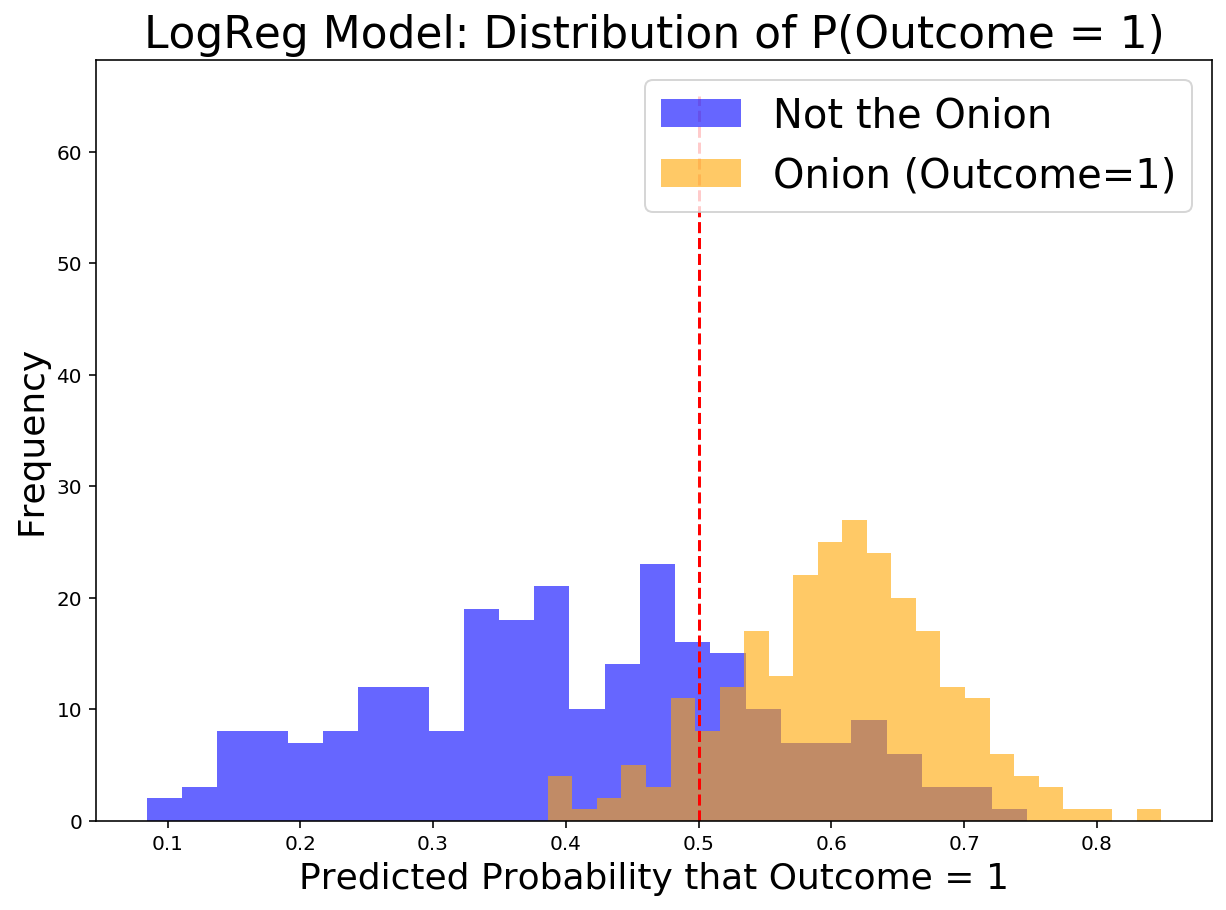

In [39]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(results_log[results_log['actual'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Not the Onion')
plt.hist(results_log[results_log['actual'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Onion (Outcome=1)')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Label axes.
plt.title('LogReg Model: Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

### Now make the curve

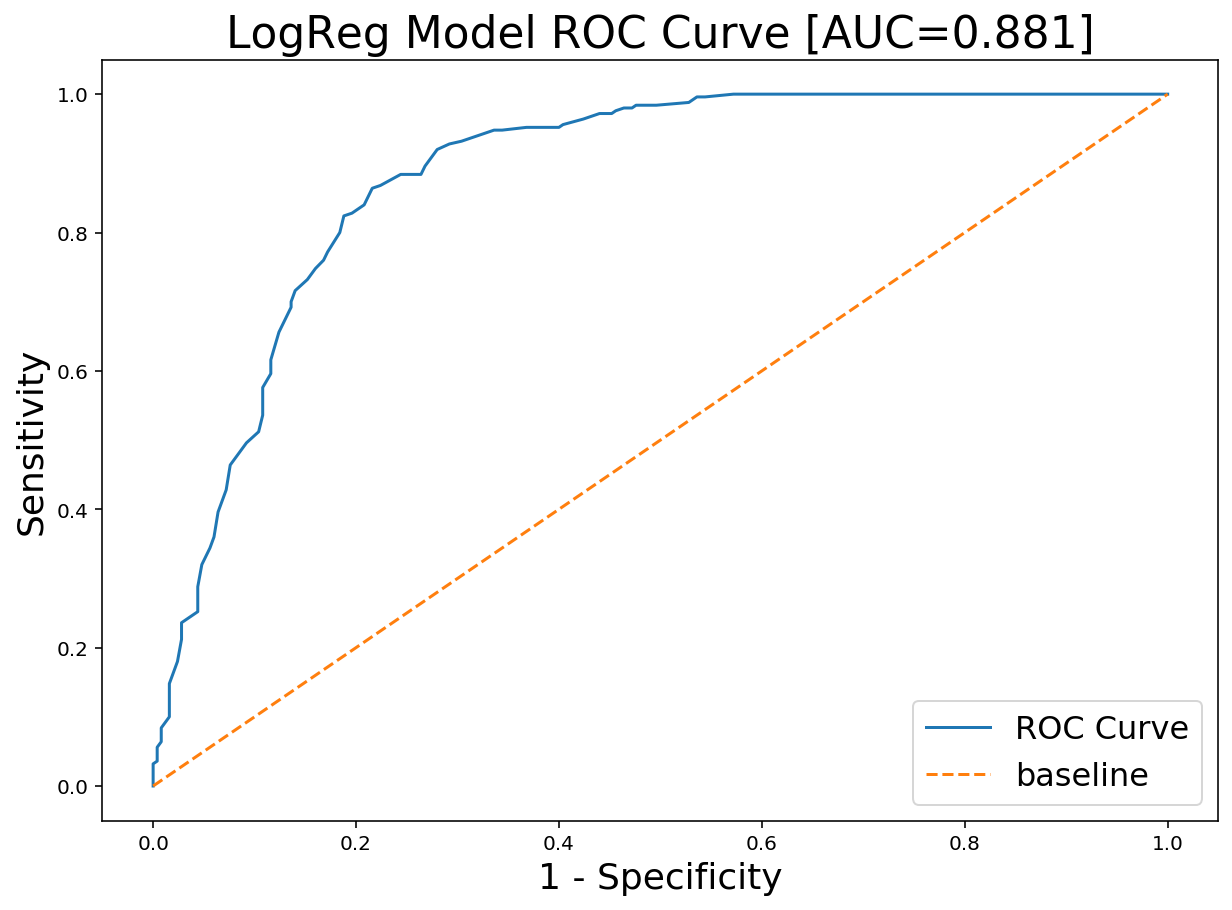

In [40]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(results_log, 'actual', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(results_log, 'actual', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"LogReg Model ROC Curve [AUC={round(roc_auc_score(results_log['actual'], results_log['pred_probs']), 3)}]", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [196]:
1-FPR(results_log, 'actual', 'pred_probs', .5)

0.732

### Now make a Distribution for the Random Forrest model, one of the worse performers

In [41]:
results_rf = pd.DataFrame(grid_rf.predict(X_test), columns=['predicted'])
results_rf['actual'] = np.where(y_test==1, 1, 0)
results_rf['post'] = list(X_test)
results_rf['grade'] = np.where(results_rf['predicted'] != results_rf['actual'], 'wrong', 'right')
results_rf['pred_probs'] = [i[1] for i in grid_rf.predict_proba(X_test)]


In [42]:
results_rf.groupby(by='grade').head();

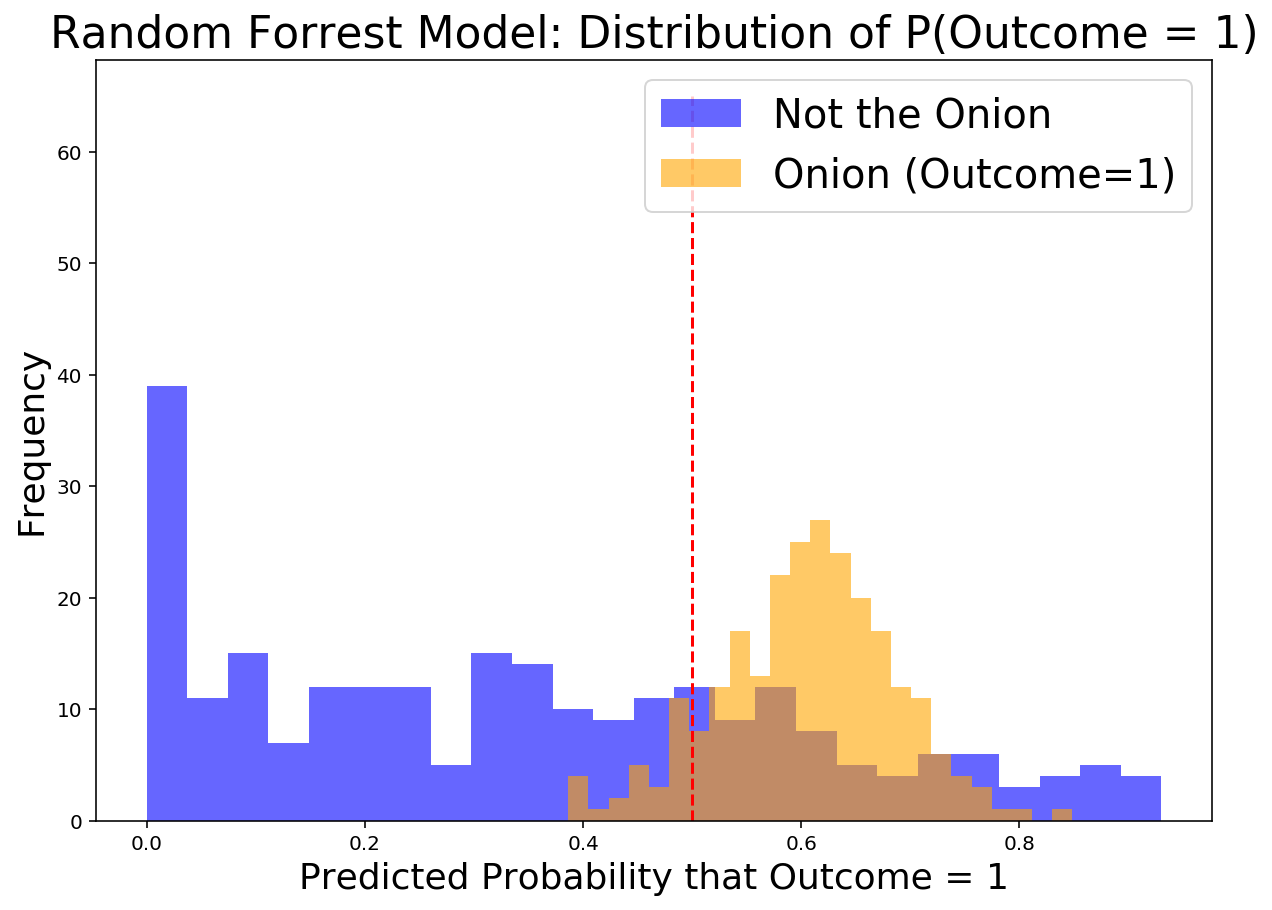

In [43]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(results_rf[results_rf['actual'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Not the Onion')
plt.hist(results_log[results_rf['actual'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Onion (Outcome=1)')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Label axes.
plt.title('Random Forrest Model: Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

### Now make curve

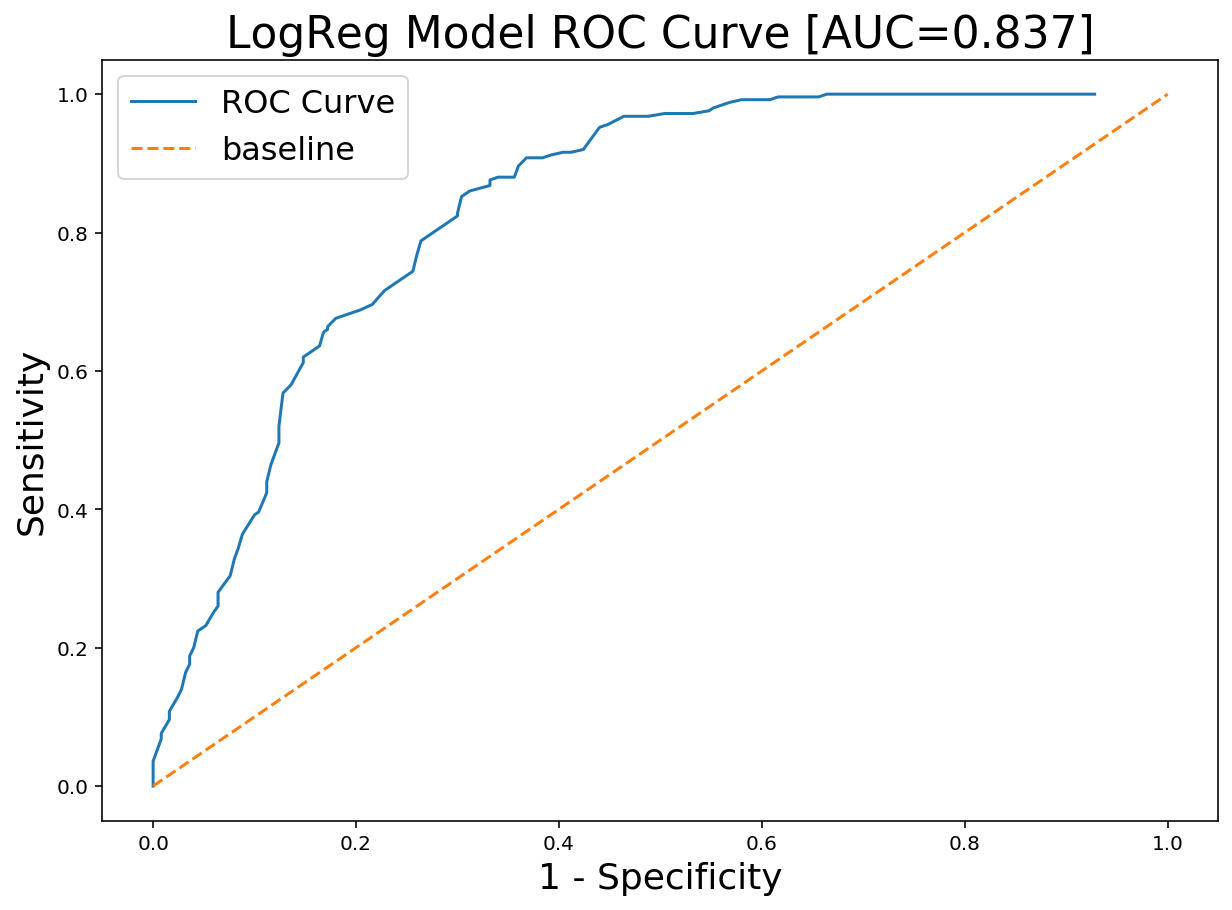

In [44]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(results_rf, 'actual', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(results_rf, 'actual', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"LogReg Model ROC Curve [AUC={round(roc_auc_score(results_rf['actual'], results_rf['pred_probs']), 3)}]", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Plot Multinomial NB Distribution of Outcomes

In [71]:
results_mnb = pd.DataFrame(grid_mnb.predict(X_test), columns=['predicted'])
results_mnb['actual'] = np.where(y_test==1, 1, 0)
results_mnb['post'] = list(X_test)
results_mnb['grade'] = np.where(results_mnb['predicted'] != results_mnb['actual'], 'wrong', 'right')
results_mnb['pred_probs'] = [i[1] for i in grid_mnb.predict_proba(X_test)]


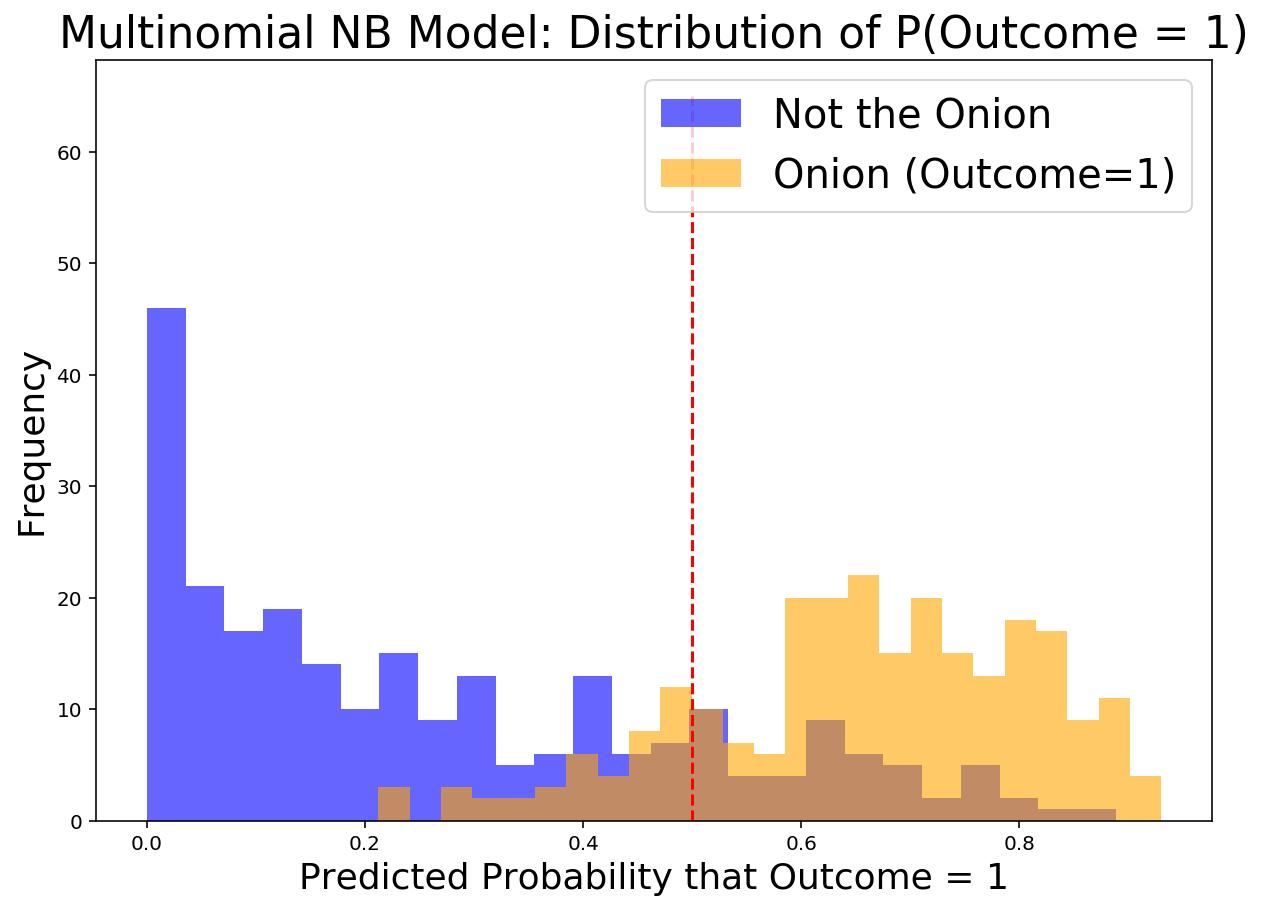

In [72]:
plt.figure(figsize = (10,7))
plt.hist(results_mnb[results_mnb['actual'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Not the Onion')
plt.hist(results_mnb[results_mnb['actual'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Onion (Outcome=1)')
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')
plt.title('Multinomial NB Model: Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)
plt.legend(fontsize = 20);

### Make the curve

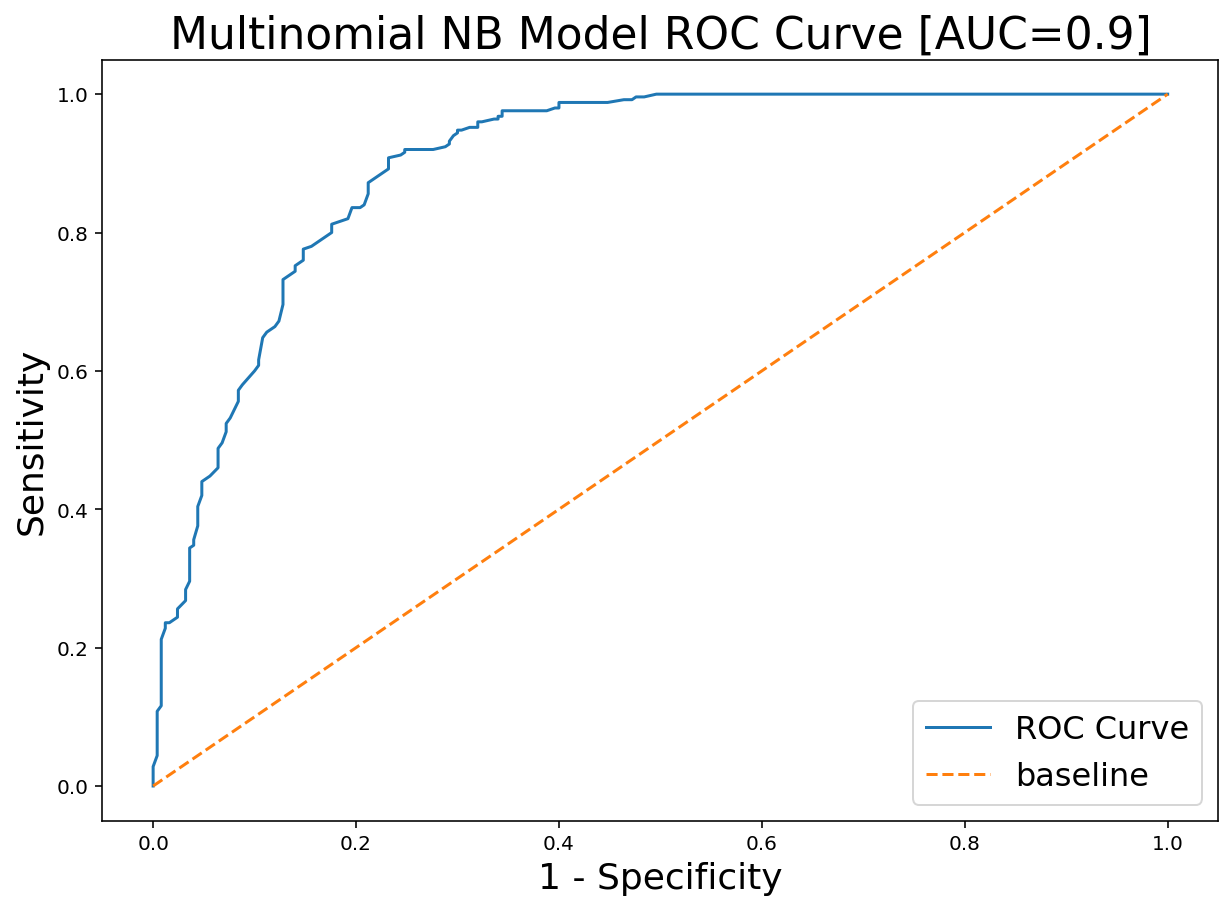

In [178]:
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(results_mnb, 'actual', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(results_mnb, 'actual', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"Multinomial NB Model ROC Curve [AUC={round(roc_auc_score(results_mnb['actual'], results_mnb['pred_probs']), 3)}]", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [197]:
1 - FPR(results_mnb, 'actual', 'pred_probs', .5)

0.808

## Investigate Lower/Higher Frequency words for logistic regression in the Corpus

In [166]:
model2 = log_grid_1.best_estimator_

In [168]:
coef2 = model2.named_steps['log'].coef_[0]
cols2 = model2.named_steps['tf'].get_feature_names()
words_df2 = pd.DataFrame(zip(cols2,coef2), columns=['words', 'coefficient'])

In [183]:
words_df2.sort_values(by='coefficient').head(11).round(2)

,words,coefficient
10036,man,-2.18
12783,police,-1.47
3870,coronavirus,-1.44
9328,kobe,-1.21
14274,says,-1.16
2567,bryant,-1.11
9330,kobe bryant,-1.06
1801,bank,-0.99
6181,for,-0.99
4611,dies,-0.97


In [185]:
words_df2.sort_values(by='coefficient', ascending=False).head(11).round(2)

,words,coefficient
11328,of,1.66
16672,this,1.65
11884,onion,1.21
1881,be,1.16
10849,nation,1.06
9104,just,0.92
19110,you,0.90
16848,to,0.86
7297,has,0.83
10964,new,0.83


## Investigate Lower/Higher Frequency words for mnb in the Corpus

In [186]:
model3 = grid_mnb.best_estimator_

In [188]:
coef3 = model3.named_steps['mnb'].coef_[0]
cols3 = model3.named_steps['tf'].get_feature_names()
words_df3 = pd.DataFrame(zip(cols3,coef3), columns=['words', 'coefficient'])

In [193]:
words_df3.sort_values(by='coefficient').head().round(2)

,words,coefficient
0,00,-10.18
12009,origin behind,-10.18
4934,doughnut drama,-10.18
12013,originated,-10.18
12014,originated in,-10.18


In [194]:
words_df3.sort_values(by='coefficient', ascending=False).head().round(2)

,words,coefficient
16848,to,-6.51
11328,of,-6.65
16219,the,-6.66
8213,in,-6.98
6181,for,-7.27
